# Assignment 2 - Q-Learning and Expected Sarsa

Welcome to Course 2 Programming Assignment 2. In this notebook, you will:

1. Implement Q-Learning with $\epsilon$-greedy action selection
2. Implement Expected Sarsa with $\epsilon$-greedy action selection
3. Investigate how these two algorithms behave on Cliff World (described on page 132 of the textbook)

We will provide you with the environment and infrastructure to run an experiment (called the experiment program in RL-Glue). This notebook will provide all the code you need to run your experiment and visualise learning performance.

This assignment will be graded automatically by comparing the behavior of your agent to our implementations of Expected Sarsa and Q-learning. The random seed will be set to avoid different behavior due to randomness. We will highlight the functions you have to use for generating random samples and the number of times these functions should be called. 

## Packages

You will need the following libraries for this assignment. We are using:
1. numpy: the fundamental package for scientific computing with Python.
2. scipy: a Python library for scientific and technical computing.
3. matplotlib: library for plotting graphs in Python.
4. RL-Glue: library for reinforcement learning experiments.

DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem

from rl_glue import RLGlue
from agent import BaseAgent
import cliffworld_env

In [3]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Q-Learning

In this section you will implement and test a Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in the textbook). 

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [6]:
# -----------
# Graded Cell
# -----------

class QLearningAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, observation):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            observation (int): the state observation from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (int): the state observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        # --------------------------
        # your code here
        
        # --------------------------
        if self.prev_state is not None:
            
            # --- FIX: Calculate max_q_next using np.max() ---
            # Q-Learning (Off-Policy): Use the value of the optimal action max_a' Q(S_t, a')
            max_q_next = np.max(current_q) 
            # Note: current_q is self.q[state, :] where state is S_{t+1}
            # --------------------------------------------------
            print(f"action is {action} and max_q is {max_q_next}")
            # TD Target
            td_target = reward + self.discount * max_q_next
            
            # 2. Calculate the TD Error: 
            old_q = self.q[self.prev_state, self.prev_action]
            td_error = td_target - old_q
            
            # 3. Update the Q-value: 
            self.q[self.prev_state, self.prev_action] += self.step_size * td_error            
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        # --------------------------
        # your code here
        
        # --------------------------
        # S_t is the state that led to termination (self.prev_state)
        # A_t is the action taken from S_t (self.prev_action)
        # R_{t+1} is the final reward received (reward)
        # S_{t+1} is the terminal state (value = 0)

        # 1. Calculate the final TD Target.
        # TD Target = R_{t+1} + gamma * V(S_{terminal}) 
        # Since V(S_terminal) is 0, the target is simply the final reward.
        td_target = reward 
        
        # 2. Calculate the TD Error
        old_q = self.q[self.prev_state, self.prev_action]
        td_error = td_target - old_q
        
        # 3. Update the Q-value
        self.q[self.prev_state, self.prev_action] += self.step_size * td_error        
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [7]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = QLearningAgent()
agent.agent_init(agent_info)
action = agent.agent_start(0)

expected_values = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

assert np.all(agent.q == expected_values)
assert action == 1

# reset the agent
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

action = agent.agent_step(2, 1)
assert action == 3

action = agent.agent_step(0, 0)
assert action == 1

expected_values = np.array([
    [0.,  0.2,  0.,  0.  ],
    [0.,  0.,   0.,  0.02],
    [0.,  0.,   0.,  0.  ],
])
assert np.all(np.isclose(agent.q, expected_values))

# reset the agent
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

action = agent.agent_step(2, 1)
assert action == 3

agent.agent_end(1)

expected_values = np.array([
    [0.,  0.2, 0.,  0. ],
    [0.,  0.,  0.,  0.1],
    [0.,  0.,  0.,  0. ],
])
assert np.all(np.isclose(agent.q, expected_values))

# Run a few more tests to ensure the epsilon-random action is not picked in the update
expected_values = np.array([
    [0.,         0.2,        0.,         0.        ],
    [5.97824336, 5.75000715, 5.79372928, 6.69483878],
    [0.,         0.,         0.,         0.        ],
])
agent.epsilon = 1.0  # Set epsilon high so that there is a larger chance to catch the errors
for _ in range(100):
    agent.agent_step(2, 1)
assert np.all(np.isclose(agent.q, expected_values))

action is 3 and max_q is 0.0
action is 1 and max_q is 0.2
action is 3 and max_q is 0.0
action is 1 and max_q is 0.1
action is 2 and max_q is 0.30000000000000004
action is 2 and max_q is 0.30000000000000004
action is 0 and max_q is 0.30000000000000004
action is 2 and max_q is 0.43699999999999994
action is 2 and max_q is 0.43699999999999994
action is 1 and max_q is 0.637
action is 0 and max_q is 0.837
action is 3 and max_q is 0.837
action is 1 and max_q is 0.837
action is 3 and max_q is 0.837
action is 3 and max_q is 0.837
action is 3 and max_q is 0.837
action is 3 and max_q is 0.987527
action is 0 and max_q is 1.187527
action is 1 and max_q is 1.387527
action is 3 and max_q is 1.387527
action is 3 and max_q is 1.387527
action is 3 and max_q is 1.587527
action is 0 and max_q is 1.7875269999999999
action is 0 and max_q is 1.9875269999999998
action is 1 and max_q is 1.9875269999999998
action is 0 and max_q is 1.9875269999999998
action is 0 and max_q is 1.9875269999999998
action is 2 and ma

# Expected Sarsa

In this section you will implement an Expected Sarsa agent with $\epsilon$-greedy action selection (Section 6.6 in the textbook). 

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [22]:
# -----------
# Graded Cell
# -----------

class ExpectedSarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, observation):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            observation (int): the state observation from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (int): the state observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        # --------------------------
        # your code here
        
        # --------------------------
        
        
        expected_q = 0.0
        for a in range(self.num_actions):
            if a == action:
                prob = 1 - self.epsilon + self.epsilon / self.num_actions
            else:
                prob = self.epsilon / self.num_actions
            expected_q += prob * self.q[state, a]
        
        # Expected SARSA update
        td_target = reward + self.discount * expected_q
        self.q[self.prev_state, self.prev_action] += self.step_size * (td_target - self.q[self.prev_state, self.prev_action])

        
        self.prev_state = state
        self.prev_action = action

        return action    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        # --------------------------
        # your code here
        
        # --------------------------
        # S_t = self.prev_state, A_t = self.prev_action, R_{t+1} = reward
        # V(S_terminal) = 0
        
        # 1. Calculate the final TD Target.
        td_target = reward 
        
        # 2. Calculate the TD Error
        old_q = self.q[self.prev_state, self.prev_action]
        td_error = td_target - old_q
        
        # 3. Update the Q-value
        self.q[self.prev_state, self.prev_action] += self.step_size * td_error
        
        # Reset state/action history for the next episode
        self.prev_state = None 
        self.prev_action = None        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [23]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = ExpectedSarsaAgent()
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

expected_values = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
assert np.all(agent.q == expected_values)

# ---------------
# test agent step
# ---------------

action = agent.agent_step(2, 1)
assert action == 3

action = agent.agent_step(0, 0)
assert action == 1

expected_values = np.array([
    [0, 0.2, 0, 0],
    [0, 0, 0, 0.0185],
    [0, 0, 0, 0],
])
assert np.all(np.isclose(agent.q, expected_values))

# --------------
# test agent end
# --------------

agent.agent_end(1)

expected_values = np.array([
    [0, 0.28, 0, 0],
    [0, 0, 0, 0.0185],
    [0, 0, 0, 0],
])
assert np.all(np.isclose(agent.q, expected_values))

# Solving the Cliff World

We described the Cliff World environment in the video "Expected Sarsa in the Cliff World" in Lesson 3. This is an undiscounted episodic task and thus we set $\gamma$=1. The agent starts in the bottom left corner of the gridworld below and takes actions that move it in the four directions. Actions that would move the agent off of the cliff incur a reward of -100 and send the agent back to the start state. The reward for all other transitions is -1. An episode terminates when the agent reaches the bottom right corner. 

<img src="cliffworld.png" alt="Drawing" style="width: 600px;"/>


Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.

The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

In [24]:
# ---------------
# Discussion Cell
# ---------------
np.random.seed(0)

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 200 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-100,0)
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

action is 3 and max_q is 0.0
action is 1 and max_q is 0.0
action is 0 and max_q is 0.0
action is 0 and max_q is 0.0
action is 0 and max_q is 0.0
action is 2 and max_q is 0.0
action is 2 and max_q is 0.0
action is 1 and max_q is -0.5
action is 3 and max_q is -0.5
action is 1 and max_q is 0.0
action is 3 and max_q is -0.75
action is 2 and max_q is 0.0
action is 0 and max_q is 0.0
action is 0 and max_q is 0.0
action is 1 and max_q is 0.0
action is 3 and max_q is -0.875
action is 3 and max_q is 0.0
action is 1 and max_q is 0.0
action is 0 and max_q is -0.5
action is 1 and max_q is 0.0
action is 3 and max_q is -0.9375
action is 2 and max_q is -0.5
action is 2 and max_q is -0.5
action is 3 and max_q is -0.5
action is 2 and max_q is 0.0
action is 0 and max_q is 0.0
action is 0 and max_q is 0.0
action is 2 and max_q is 0.0
action is 2 and max_q is 0.0
action is 3 and max_q is 0.0
action is 3 and max_q is 0.0
action is 3 and max_q is 0.0
action is 0 and max_q is 0.0
action is 1 and max_q is 0.0

  1%|          | 1/100 [00:00<01:14,  1.34it/s]


action is 3 and max_q is -6.0
action is 0 and max_q is -6.947508100880405
action is 0 and max_q is -5.961369173951626
action is 1 and max_q is -4.9866697701988265
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_

  2%|▏         | 2/100 [00:01<01:14,  1.32it/s]


action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 1 and max_q is -4.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 1 and max_q is -12.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0

  3%|▎         | 3/100 [00:02<01:14,  1.30it/s]

action is 3 and max_q is -11.457225193016711
action is 0 and max_q is -11.046840391157275
action is 2 and max_q is -10.512787852487236
action is 1 and max_q is -11.279814121822255
action is 3 and max_q is -11.515983575584734
action is 0 and max_q is -11.279814121822255
action is 0 and max_q is -10.559214206876732
action is 1 and max_q is -9.695633355062455
action is 0 and max_q is -9.865282170243335
action is 0 and max_q is -8.92879730645958
action is 0 and max_q is -7.969436474177915
action is 0 and max_q is -6.984100760408656
action is 0 and max_q is -5.992018182726266
action is 0 and max_q is -4.995618691241601
action is 0 and max_q is -3.99776844255537
action is 0 and max_q is -2.9992923986145668
action is 1 and max_q is -1.9999999824266257
action is 2 and max_q is -1.0
action is 0 and max_q is -2.0
action is 3 and max_q is -1.0
action is 1 and max_q is -1.9999999912133128
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and ma

  4%|▍         | 4/100 [00:03<01:12,  1.33it/s]


action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 3 and max_q is -7.0
action is 0 and max_q is -7.912396305095292
action is 1 and max_q is -6.956268761132405
action is 0 and max_q is -6.0
action is 1 and max_q is -5.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 3 and max_q is -12.0
action is 3 and max_q is -11.587218775394831
action is 2 and max_q is -11.364660795617965
action is 2 and max_q is -11.3646

  5%|▌         | 5/100 [00:03<01:12,  1.31it/s]

action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 3 and max_q is -6.0
action is 1 and max_q is -6.972063770523869
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and m

  6%|▌         | 6/100 [00:04<01:12,  1.30it/s]

action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 3 and max_q is -8.0
action is 0 and max_q is -8.878069547779962
action is 0 and max_q is -7.922553902717681
action is 0 and max_q is -6.947824105174136
action is 3 and max_q is -5.979382868207551
action is 0 and max_q is -6.5331417632551165
action is 0 and max_q i

  7%|▋         | 7/100 [00:05<01:10,  1.32it/s]

action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 2 and max_q is -12.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
act

  8%|▊         | 8/100 [00:06<01:08,  1.34it/s]

action is 2 and max_q is -8.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 1 and max_q is -4.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 3 and max_q is -5.0
action is 0 and max_q is -5.988903293333522
action is 0 and max_q is -4.997546682292997
action is 0 and max_q is -3.998974740422593
action is 0 and max_q

  9%|▉         | 9/100 [00:06<01:09,  1.31it/s]


action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 2 and max_q is -6.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 2 and max_q is -4.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 2 and max_q is -9.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 2 and max_q is -6.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 2 and max_q is -4.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
act

 10%|█         | 10/100 [00:07<01:08,  1.31it/s]


action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 1 and max_q is -2.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0


 11%|█         | 11/100 [00:08<01:07,  1.32it/s]


action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 1 and max_q is -9.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 3 and max_q is -4.0
action is 0 and max_q is -4.995477267596684
action is 0 and max_q is -3.998576128475446
action is 0 and max_q is -2.999897898452022
action is 1 and max_q is -1.99999995055939
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
acti

 12%|█▏        | 12/100 [00:09<01:07,  1.31it/s]

action is 1 and max_q is -8.716173555376088
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 3 and max_q is -4.0
action is 0 and max_q is -4.978509036846914
action is 0 and max_q is -3.992923969381706
action is 0 and max_q is -2.996724620087626
action is 1 and max_q is -1.9999991576002252
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q i

 13%|█▎        | 13/100 [00:10<01:11,  1.21it/s]


action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 2 and max_q is -7.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 3 and max_q is -4.0
action is 1 and max_q is -4.992139275265168
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 3 and max_q is -2.0
action is 0 and max_q is -2.9997839257055974
action is 1 and max_q is -1.9999999537806974
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and ma

 14%|█▍        | 14/100 [00:10<01:08,  1.26it/s]


action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 1 and max_q is -2.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0


 15%|█▌        | 15/100 [00:11<01:05,  1.30it/s]


action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 3 and max_q is -11.0
action is 0 and max_q is -11.455834225673662
action is 3 and max_q is -10.667595638296916
action is 1 and max_q is -10.463968024707356
action is 0 and max_q is -10.696683934379525
action is 0 and max_q is -9.796054517119478
action is 0 and max_q is -8.915528399441264
action is 0 and max_q is -7.967971171009236
action is 1 and max_q is -6.986628843634726
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 3 and max_q is -1.0
action is 1 and max_q is -1.9999999759810967
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 2 and max_q is -10.0
action is 0 and max_q is -11.0
action is 0 and max_q 

 16%|█▌        | 16/100 [00:12<01:04,  1.30it/s]


action is 0 and max_q is -7.144991053268313
action is 0 and max_q is -6.413800688460469
action is 0 and max_q is -5.536168196122162
action is 0 and max_q is -4.699373705305334
action is 0 and max_q is -3.8823447381186225
action is 0 and max_q is -2.984136663249185
action is 1 and max_q is -2.984136663249185
action is 1 and max_q is -1.9999995422403702
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 3 and max_q is -9.0
action is 3 and max_q is -9.668331833090633
action is 3 and max_q is -9.326235489686951
action is 3 and max_q is -9.326235489686951
action is 0 and max_q is -9.51891374252591
action is 0 and max_q is -8.850271562463604
action is 1 and max_q is -8.066549019888043
action is 0 and max_q is -7.896248657126161
action is 1 and max_q is -6.932470138863255
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q

 17%|█▋        | 17/100 [00:13<01:04,  1.28it/s]

action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 3 and max_q is -6.0
action is 2 and max_q is -6.953497641527866
action is 0 and max_q is -7.917969047807123
action is 0 and max_q is -6.953497641527866
action is 0 and max_q is -5.969930667573886
action is 0 and max_q is -4.984221981902573
action is 1 and max_q is -3.9961008408958274
action is 1 and max_q is -3.0
action is 3 and max_q is -13.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action

 18%|█▊        | 18/100 [00:13<01:02,  1.31it/s]


action is 1 and max_q is -1.9999999183125676
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 2 and max_q is -6.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 3 and max_q is -1.0
action is 1 and max_q is -1.9999999591562838
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 0 and max_q is -11.0
a

 19%|█▉        | 19/100 [00:14<01:02,  1.30it/s]

action is 0 and max_q is -11.0
action is 0 and max_q is -10.0
action is 0 and max_q is -9.0
action is 0 and max_q is -8.0
action is 0 and max_q is -7.0
action is 0 and max_q is -6.0
action is 0 and max_q is -5.0
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and max_q is -2.0
action is 1 and max_q is -1.0
action is 0 and max_q is -12.0
action is 3 and max_q is -11.0
action is 3 and max_q is -11.17840590034632
action is 0 and max_q is -10.710863839596101
action is 0 and max_q is -10.200382429495221
action is 1 and max_q is -9.492538981634425
action is 3 and max_q is -9.632705506955972
action is 0 and max_q is -9.550091372155293
action is 0 and max_q is -8.688269406193285
action is 0 and max_q is -8.116383713335381
action is 1 and max_q is -7.215983789094025
action is 0 and max_q is -6.916727838877703
action is 0 and max_q is -5.960680179059478
action is 1 and max_q is -4.982625355909477
action is 0 and max_q is -4.0
action is 0 and max_q is -3.0
action is 0 and 

 19%|█▉        | 19/100 [00:14<01:02,  1.29it/s]


action is 0 and max_q is -0.5
action is 1 and max_q is -0.5
action is 1 and max_q is 0.0
action is 1 and max_q is 0.0
action is 2 and max_q is -2.0625
action is 2 and max_q is -2.0625
action is 1 and max_q is -2.15625
action is 1 and max_q is -2.15625
action is 3 and max_q is -2.24609375
action is 0 and max_q is -1.625
action is 0 and max_q is -0.875
action is 2 and max_q is -0.75
action is 3 and max_q is -1.25
action is 3 and max_q is -1.0
action is 1 and max_q is -1.0
action is 1 and max_q is -1.3125
action is 0 and max_q is -1.3125
action is 0 and max_q is -0.75
action is 3 and max_q is -0.75
action is 0 and max_q is -0.5
action is 1 and max_q is 0.0
action is 1 and max_q is 0.0
action is 3 and max_q is -2.435546875
action is 3 and max_q is -1.75
action is 3 and max_q is -1.25
action is 1 and max_q is -1.0
action is 0 and max_q is -1.625
action is 2 and max_q is -1.375
action is 0 and max_q is -1.625
action is 0 and max_q is -1.375
action is 0 and max_q is -1.0
action is 1 and max_

KeyboardInterrupt: 

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

NameError: name 'all_state_visits' is not defined

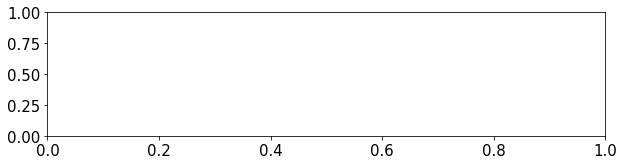

In [14]:
# ---------------
# Discussion Cell
# ---------------

for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

The Q-learning agent learns the optimal policy, one that moves along the cliff and reaches the goal in as few steps as possible. However, since the agent does not follow the optimal policy and uses $\epsilon$-greedy exploration, it occasionally falls off the cliff. The Expected Sarsa agent takes exploration into account and follows a safer path.


Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

This cell takes around 10 minutes to run. The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

In [ ]:
# ---------------
# Discussion Cell
# ---------------
from itertools import product

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

Expected Sarsa shows an advantage over Q-learning in this problem across a wide range of step-sizes.

Congratulations! Now you have:

- implemented Q-Learning with $\epsilon$-greedy action selection
- implemented Expected Sarsa with $\epsilon$-greedy action selection
- investigated the behavior of these two algorithms on Cliff World